In [1]:
import torch
from torchvision.models import vgg19
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
vgg_model = vgg19()
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [3]:
summary(vgg_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [4]:
from PIL import Image

In [5]:
content = Image.open("../data/content.jpg").resize((224, 224))
style = Image.open("../data/style.jpg").resize((224, 224))

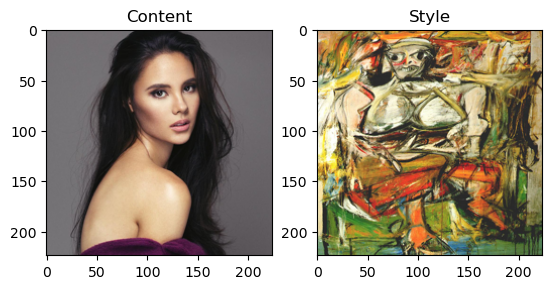

In [6]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(content)
axs[0].title.set_text("Content")
axs[1].imshow(style)
axs[1].title.set_text("Style")

In [7]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor()])
content_tensor = transform(content).unsqueeze(0)
style_tensor = transform(style).unsqueeze(0)
style_tensor.shape, content_tensor.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [8]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [9]:
vgg_model.to(device)
for name, tensor in vgg_model.named_parameters():
    tensor.requires_grad = False

In [10]:
def extract_features(layers, image, model):
    features = {}
    x = image.clone().to(device)
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features

In [11]:
layers = ["0", "2", "5", "7", "10", "12", "14", "16", "19", "21", "23", "25", "28", "30", "32", "34"]
content_features = extract_features(layers, content_tensor, vgg_model.features)
style_features = extract_features(layers, style_tensor, vgg_model.features)

In [12]:
def get_gram_matrix(activation):
    b, c, h, w = activation.shape
    gram_matrices = []
    for i in range(b):
        curr_activation = activation[i].reshape(c, h * w)
        gram_matrices.append(torch.matmul(curr_activation, curr_activation.T))
    return torch.stack(gram_matrices)

In [13]:
style_gram_features = {}
for name, activation in style_features.items():
    style_gram_features[name] = get_gram_matrix(activation)

### Training Model

In [14]:
from torch.optim import Adam
import torch.nn.functional as f
from tqdm import tqdm
import numpy as np

In [15]:
def imcnvt(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1, 2, 0)
    x = x * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    return np.clip(x, 0, 1)

In [16]:
x = content_tensor.clone()
x.requires_grad = True
x.shape

torch.Size([1, 3, 224, 224])

In [17]:
optimizer = Adam([x], lr = 0.05)
epochs = 1000
logging_step = 100
content_weight = 100
style_weight = 1e8
style_grams_weights = {layer : 1 / (int(layer) + 1) for layer in layers}

In [26]:
losses = []
for epoch in tqdm(range(epochs)):
    activations = extract_features(layers, x, vgg_model.features)
    content_loss, style_loss = 0, 0
    for layer in layers:
        b, c, h, w = activations[layer].shape
        current_grams = get_gram_matrix(activations[layer])
        style_loss += (f.mse_loss(current_grams, style_gram_features[layer]) / (c * h * w)) * style_grams_weights[layer]
        content_loss += f.mse_loss(activations[layer], content_features[layer])
    total_loss = content_weight * content_loss + style_weight * style_loss
    losses.append(total_loss.item())
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % logging_step == 0:
        plt.imsave("../results/" + str(epoch + 1) + '.png', imcnvt(x), format='png')

100%|███████████████████████████████████████| 1000/1000 [11:06<00:00,  1.50it/s]


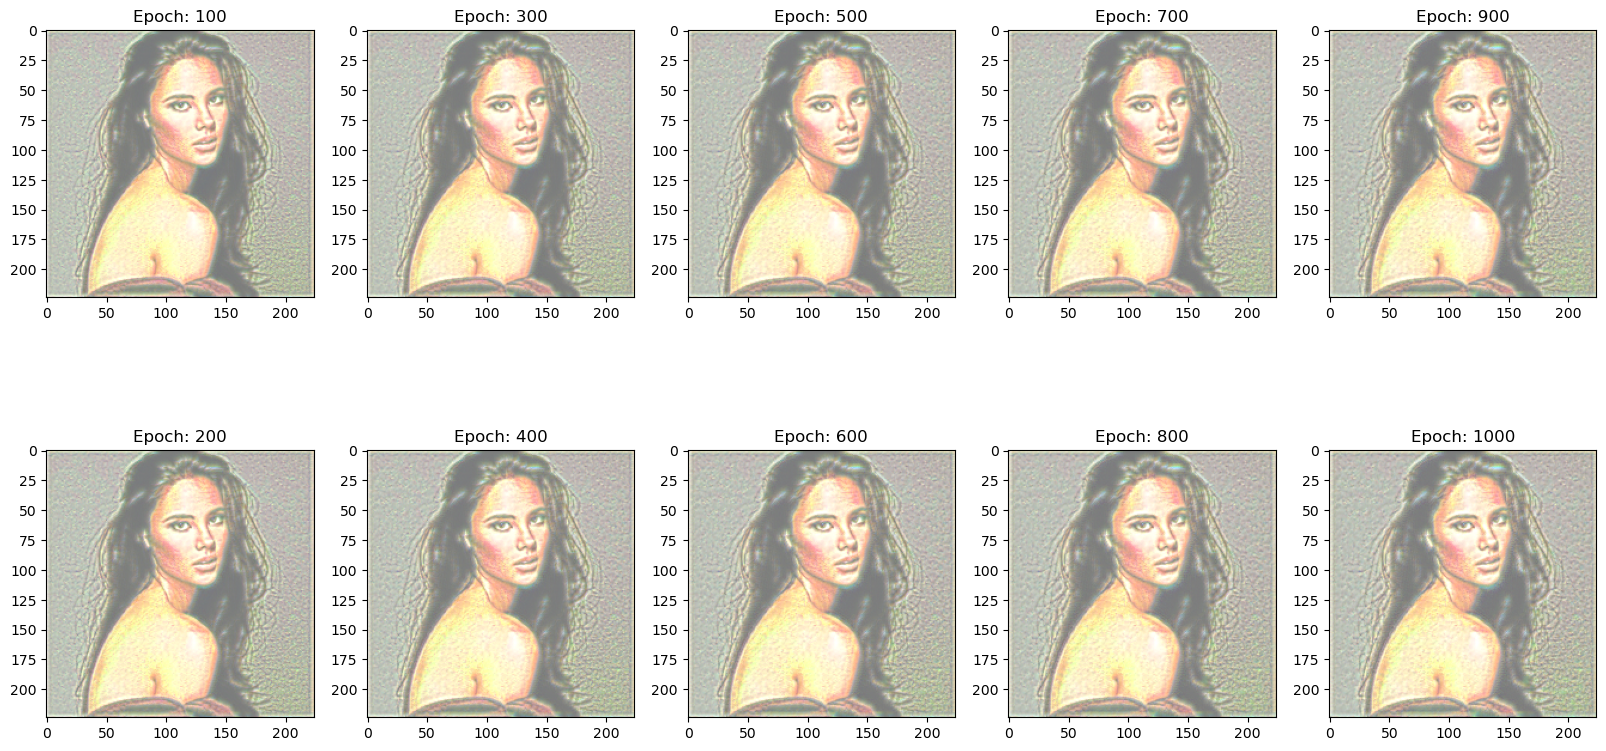

In [27]:
names = [i * 100 for i in range(1, 11)]
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(5):
    axs[0][i].set_title(f"Epoch: {names[2 * i]}")
    axs[0][i].imshow(Image.open(f"../results/{names[2 * i]}.png"))
    axs[1][i].set_title(f"Epoch: {names[2 * i + 1]}")
    axs[1][i].imshow(Image.open(f"../results/{names[2 * i + 1]}.png"))
plt.show()

In [28]:
PATH = "../objs/vgg_features.pt"
torch.save(vgg_model.features, PATH)

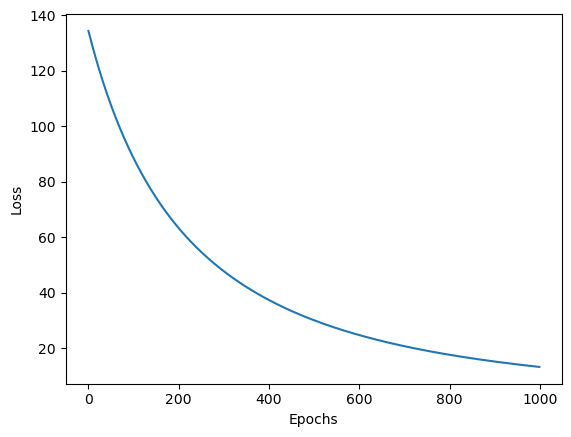

In [29]:
plt.plot(list(range(epochs)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()